In [24]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
import pandas as pd
import numpy as np

import seaborn as sns
sns.set()

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import learning_curve

In [2]:
# load the data
df = pd.read_csv('./Data/Final_18_features_extracted_V2.csv')

In [3]:
df.head()

,Region,File Name,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12,MFCC13,AMP_ENV,RMSE,ZCR,SPEC_CENT,SPEC_BAND
0,Barisal,br1.wav,-371.58478,97.99681,1.269639,26.940123,-5.517467,-7.585458,-12.512117,-10.121937,-17.117098,-2.980860,-5.495219,-6.685885,-2.246712,0.094423,0.042012,0.082185,1389.448490,1475.018042
1,Barisal,br10.wav,-311.64117,71.84370,-20.855787,17.992466,-9.575283,9.301216,-38.153957,-14.808104,-10.210079,-14.747650,-10.387901,-1.234518,-3.261181,0.165459,0.074938,0.179697,2307.459302,1789.181398
2,Barisal,br100.wav,-314.17575,136.41866,-52.862125,-15.473975,-45.570000,-17.382814,-19.885965,-25.647032,-8.209912,-17.986666,-11.351544,-1.021543,-9.109297,0.108455,0.048392,0.070920,1157.114627,1057.426180
3,Barisal,br1000.wav,-411.62485,180.74176,-21.907639,-30.858137,14.736920,-6.635318,-30.891031,-23.473873,-18.243060,-22.557762,-11.455458,0.803584,-9.340458,0.045525,0.023924,0.049118,755.861500,628.356257
4,Barisal,br1001.wav,-395.18910,115.52895,-60.058544,-21.238525,-16.252647,-4.061910,-12.676420,-23.779793,-25.017618,-18.328882,-6.299292,-8.562610,-16.118456,0.043661,0.021089,0.101046,1474.438870,1225.782428


- First drop 'File Name' columns as we are gonna use default indexing
- Make X and y

In [4]:
X = df.drop(columns=["Region","File Name"],axis=1)
y = df['Region']

In [5]:
X.shape, y.shape

((9059, 18), (9059,))

- Making train test split


In [6]:
X_train,X_test,y_train,y_test = train_test_split(
    X,y,test_size=0.3,random_state=17,shuffle=True
)

- Lets build our Random Forest model with default parameters now
  - Also we need our skf with shuffle true as CV

In [7]:
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=17)

rfc = RandomForestClassifier(random_state=17,n_jobs=-1)

- Lets check our CV scores with default parameters

In [8]:
results = cross_val_score(rfc,X_train,y_train,cv=skf)
results.mean()*100

77.7006535362801

- Lets do the same thing in default manner

In [9]:
rfc.fit(X_train,y_train)

RandomForestClassifier(n_jobs=-1, random_state=17)

In [10]:
# accuracy on the train set:
rfc_pred = rfc.predict(X_train)
accuracy_score(y_train,rfc_pred)

1.0

In [11]:
# accuracy on the test set
rfc_pred = rfc.predict(X_test)
accuracy_score(y_test,rfc_pred)

0.7829286239882266

### One very important thing to take note:
- The accuracy on the train set is 1 while the accuracy on the test set is .78! This is a case where the model is extremely biased towards the train set, and it cant generalize at all. Indicating **High variance** of the model.We might try three things here!
  - Add more training data (Not possible)
  - Reduce model complexity (Gotta do this first)
  - Bagging! (will do second if i have time)

## Hyperparameter tuning:

In [12]:
forest_params = {'max_features': [4, 7, 10, 13],
              'min_samples_leaf': [1, 3, 5, 7],
              'max_depth': [5, 10, 15, 20]}
rfc = RandomForestClassifier(n_estimators=100,random_state=17,n_jobs=-1)

gcv = GridSearchCV(rfc,forest_params,n_jobs=-1,cv=skf,verbose=1)

In [13]:
# Lets train the model
gcv.fit(X_train,y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=-1, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [4, 7, 10, 13],
                         'min_samples_leaf': [1, 3, 5, 7]},
             verbose=1)

In [14]:
gcv.best_score_

0.7766924451802633

In [15]:
gcv.best_params_

{'max_depth': 20, 'max_features': 7, 'min_samples_leaf': 1}

In [16]:
gcv.best_estimator_

RandomForestClassifier(max_depth=20, max_features=7, n_jobs=-1, random_state=17)

In [17]:
forest_pred = gcv.best_estimator_.predict(X_test)

In [18]:
accuracy_score(y_test,forest_pred) # accuracy on the test set

0.7744665194996321

- Lets plot the Learning curve

In [26]:
alphas = np.logspace(-2, 0, 20)
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, "-", **kwargs)
    plt.fill_between(
        x,
        mu - std,
        mu + std,
        edgecolor="none",
        facecolor=lines[0].get_color(),
        alpha=0.2,
    )


In [33]:
def plot_learning_curve(degree=2,alphas=0.01):
    train_sizes = np.linspace(0.05,1,20)
    N_train,val_train,val_test = learning_curve(
        gcv.best_estimator_,X_train,y_train,train_sizes=train_sizes,cv=skf
    )
    plot_with_err(N_train, val_train, label="training scores")
    plot_with_err(N_train, val_test, label="validation scores")
    plt.xlabel("Training Set Size")
    plt.ylabel("AUC")
    plt.legend()
    plt.grid(True);

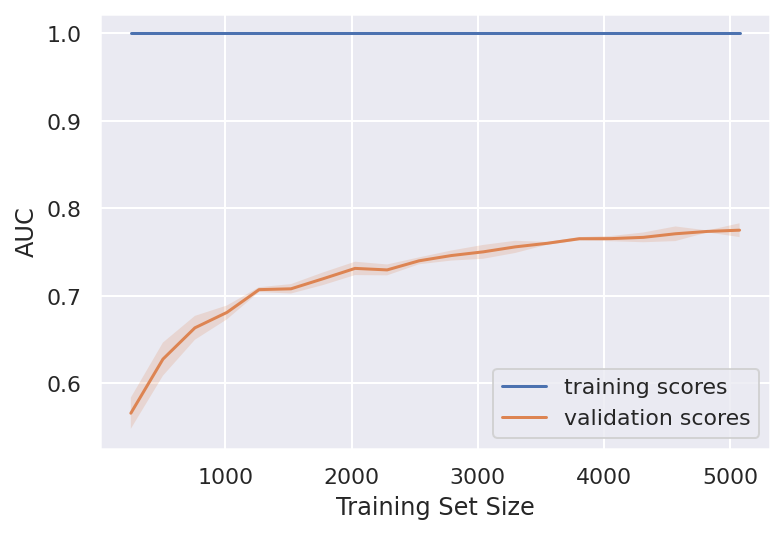

In [34]:
plot_learning_curve(degree=2,alphas=10)

- for RF, only oob error i.e. using only those trees that were not trained on the case or validation/vreification with proper unknown cases are relevant.

- So now lets do bootstrapping to see whether we can tame the training score always 100 by enabling OOB error!